# Test loading elevation maps

Goal is to capture all of the data in the maps, with NaNs when missing, and have a grid rotated alongshore to facilitate erosion calcs.

TODO:
* Make a rotated grid big enough to accomodate all of the maps. What resolution?
* Assign UTM values to for rotated grid.
* Load each map, [smooth?], and interpolate onto rotated grid.
* Stack all maps. Work in rotated grid coordintes.
* Save
    

In [2]:
import json
import fiona
import numpy as np
import pandas as pd
import scipy.signal
from IPython.display import display, HTML
import rasterio # rasterio and OGR don't mix...see rasterio docs
from rasterio import Affine
import matplotlib.pyplot as plt
import xarray as xr
%matplotlib inline

In [18]:
#fdir = "F:/2017_Karen_Sandwich_maps"
fdir = "C:/crs/proj/2017_Karen_Sandwich_maps"

fnames = (\
"2016-01-22_SandwichTNB_PT_DEM_10cm_trimmed.tif",\
"2016-01-25_SandwichTNB_DEM_10cm_trimmed.tif",\
"2016-02-11_SandwichTNB_DEM_10cm_trimmed.tif",\
"2016-03-30_SandwichTNB_AS_DEM_10cm_trimmed.tif",\
"2016-09-21_SandwichTNB_DEM_10cm_trimmed.tif",\
"2017-01-09_SandwichTNB_DEM_10cm_trimmed.tif",\
"2017-01-25_SandwichTNB_DEM_10cm_trimmed.tif",\
"2017-02-14_SandwichTNB_DEM_10cm_trimmed.tif",\
"2017-03-16_SandwichTNB_DEM_10cm_trimmed.tif",\
"2017-04-28_SandwichTNB_DEM_10cm_trimmed.tif",\
"2017-05-04_SandwichTNB_DEM_10cm_trimmed.tif",\
"2017-09-18_SandwichTNB_DEM_10cm_trimmed.tif",\
#"2018-01-03_SandwichTNB_DEM_10cm_trimmed.tif",\ # needs to be padded...not very good control
"2018-01-10_SandwichTNB_DEM_10cm_trimmed.tif",\
"DEM_10cm_selfcal_lokicampos_mid_denseNAD83UTM19.tif")

dslist =[]
# just read one for now (note...this reads in as a DataArray, not a DataSet)
fn = fdir+"/2016-01-22_SandwichTNB_PT_DEM_10cm_trimmed.tif"
# fn = fdir+"/2016-01-25_SandwichTNB_DEM_10cm_trimmed.tif"

da = xr.open_rasterio(fn)
#     ds = ds.sel(x=slice(e0,e1), y=slice(n0,n1))
#     if len(dslist) == 0:
#         xc = ds['x']-ds['x'].values.min()
#         yc = ds['y']-ds['y'].values.min()
#     ds['x'] = xc
#     ds['y'] = yc
#     dslist.append(ds)

In [19]:
# look to see what got loaded
print(da['x'].values[0], da['x'].values[-1], da['y'].values[0],\
      da['y'].values[-1])
# this is super slow and only successfully returns min and max
# print(stats.describe(da.values,nan_policy='omit'))
print(da.values.min(), da.values.max())
print(da.sizes)
print(da.dims)
print(da.indexes)
da.values

376286.692999 377485.292999 4625440.78441 4624418.28441
-32767.0 14.8271
Frozen(OrderedDict([('band', 1), ('y', 10226), ('x', 11987)]))
('band', 'y', 'x')
band: Int64Index([1], dtype='int64', name='band')
y: Float64Index([ 4625440.784410301,    4625440.6844103, 4625440.5844103005,
                  4625440.484410301,    4625440.3844103,  4625440.284410301,
                    4625440.1844103, 4625440.0844103005,  4625439.984410301,
                    4625439.8844103,
                 ...
                    4624419.1844103, 4624419.0844103005,  4624418.984410301,
                    4624418.8844103,  4624418.784410301,    4624418.6844103,
                 4624418.5844103005,  4624418.484410301,    4624418.3844103,
                  4624418.284410301],
                dtype='float64', name='y', length=10226)
x: Float64Index([376286.69299908396,   376286.792999084, 376286.89299908397,
                 376286.99299908394,   376287.092999084, 376287.19299908396,
                   376287.

array([[[-32767., -32767., -32767., ..., -32767., -32767., -32767.],
        [-32767., -32767., -32767., ..., -32767., -32767., -32767.],
        [-32767., -32767., -32767., ..., -32767., -32767., -32767.],
        ..., 
        [-32767., -32767., -32767., ..., -32767., -32767., -32767.],
        [-32767., -32767., -32767., ..., -32767., -32767., -32767.],
        [-32767., -32767., -32767., ..., -32767., -32767., -32767.]]], dtype=float32)

Example from scipy.interpolate.RegularGridInterpolator documentation
```
def ff(x,y):
...     return 2 * x**3 + 3 * y**2
x = np.linspace(1, 4, 11)
y = np.linspace(4, 7, 22)
data = ff(*np.meshgrid(x, y, indexing='ij', sparse=True))
print(np.shape(x),np.shape(y),np.shape(data))

f = interpolate.RegularGridInterpolator( (x, y), data, method='nearest')
```

In [20]:
from scipy import interpolate
print("shape of y, x, and da.values: ",\
      np.shape(np.flipud(da['y'].values)), np.shape(da['x'].values),\
      np.shape( np.flipud(da.values)) )
x = da['x'].values
y = np.flipud(da['y'].values)

# Not sure how da.values got a singleton dimension, but squeeze gets rid of it.
# However, make sure to squeeze before flipping
z = np.flipud(np.squeeze(da.values))

# smooth with 2D running median
zs = scipy.signal.medfilt2d(z, kernel_size=3)

print("Shape of x, y, and zs",np.shape(x),np.shape(y),np.shape(zs))
f = interpolate.RegularGridInterpolator( (y, x), zs, method='nearest')

shape of y, x, and da.values:  (10226,) (11987,) (1, 10226, 11987)
Shape of x, y, and zs (11987,) (10226,) (10226, 11987)


In [37]:
# make a small box w/ cell centered grid with spacing dxy
dxy = 1.
xmax = 250. # alongshore
ymax = 1700.  # cross-shore
nx = int((1./dxy)*xmax)
ny = int((1./dxy)*ymax)

# Y is decending
#xrot, yrot=np.meshgrid(np.linspace(0.,xmax,nx), np.flip(np.linspace(0.,ymax,ny),0) ,sparse=False, indexing='xy')
# Y is ascending
xrot, yrot=np.meshgrid(np.linspace(0.5*dxy,xmax-0.5*dxy,nx), np.linspace(0.5*dxy,ymax-0.5*dxy,ny) ,sparse=False, indexing='xy')
print("xrot:")
print(xrot.shape)
print(xrot)
print("yrot:")
print(yrot.shape)
print(yrot)

xrot:
(1700, 250)
[[   0.5    1.5    2.5 ...,  247.5  248.5  249.5]
 [   0.5    1.5    2.5 ...,  247.5  248.5  249.5]
 [   0.5    1.5    2.5 ...,  247.5  248.5  249.5]
 ..., 
 [   0.5    1.5    2.5 ...,  247.5  248.5  249.5]
 [   0.5    1.5    2.5 ...,  247.5  248.5  249.5]
 [   0.5    1.5    2.5 ...,  247.5  248.5  249.5]]
yrot:
(1700, 250)
[[  5.00000000e-01   5.00000000e-01   5.00000000e-01 ...,   5.00000000e-01
    5.00000000e-01   5.00000000e-01]
 [  1.50000000e+00   1.50000000e+00   1.50000000e+00 ...,   1.50000000e+00
    1.50000000e+00   1.50000000e+00]
 [  2.50000000e+00   2.50000000e+00   2.50000000e+00 ...,   2.50000000e+00
    2.50000000e+00   2.50000000e+00]
 ..., 
 [  1.69750000e+03   1.69750000e+03   1.69750000e+03 ...,   1.69750000e+03
    1.69750000e+03   1.69750000e+03]
 [  1.69850000e+03   1.69850000e+03   1.69850000e+03 ...,   1.69850000e+03
    1.69850000e+03   1.69850000e+03]
 [  1.69950000e+03   1.69950000e+03   1.69950000e+03 ...,   1.69950000e+03
    1.69950000

[-0.25355339 -0.0767767  -0.96066017 -0.78388348  0.1       ] [ 1.16066017  1.33743687  1.86776695  2.04454365  1.51421356]
[ 0.1] [ 1.51421356]


(-3, 3)

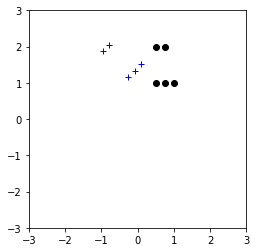

In [31]:
# test rotation matrix

#some points
xx = np.array((.5,.75,.5,.75, 1.)).T
yy = np.array((1., 1., 2., 2., 1.)).T
e0 = .1
n0 = .1

theta = 45. # degrees

def box2UTMh(x, y, x0, y0, theta):
    '''
    2D rotation and translation of x, y
    Input:
        x, y - row vectors of original coordinates (must be same size)
        x0, y0 - Offset (location of x, y = (0,0) in new coordinate system)
        theta - Angle of rotation (degrees, CCW from x-axis == Cartesian coorinates)
    Returns:
        xr, yr - rotated, offset coordinates
    '''
    thetar = np.radians(theta)
    c, s = np.cos(thetar), np.sin(thetar)

    # homogenous rotation matrix
    Rh = np.array(((c, -s,  0.),\
                   (s,  c,  0.),\
                   (0., 0., 1.)))
    # homogenous translation matrix
    Th = np.array(((1., 0., x0),\
                   (0., 1., y0),\
                   (0., 0., 1.)))
    
    # homogenous input x,y
    xyh = np.vstack((x,y,np.ones_like(x)))

    # perform rotation and translation
    xyrh=np.matmul(np.matmul(Th,Rh),xyh)
    xr = xyrh[0,:]
    yr = xyrh[1,:]
    return xr, yr

# Test with horiz arrays
xr, yr = box2UTMh( xx, yy, e0, n0, theta)
print(xr,yr)

# Test with single point
xrr, yrr = box2UTMh( 1., 1., e0, n0, theta)
print(xrr, yrr)

plt.plot(figsize=(4,4))
plt.plot(xx,yy,'ok')
plt.plot(xr,yr,'+b')
plt.axis('square')
plt.xlim([-3,3])
plt.ylim([-3,3])


In [42]:
# calculate UTM coordinates for the box, which depend on upper left hand corner and rotation

# bottom left corner of big region of interest (UTM Zone 19N meters)
e0 = 377100.; n0 = 4624400.
rot = 30.
def box2UTM(x, y, e0, n0, rot):
    # for counterclockwise rotation (right-handed cartesian coords)
    r = np.pi*(90-rot)/180.
    xnew = x*np.cos(r) - y*np.sin(r) + e0
    ynew = y*np.sin(r) + x*np.cos(r) + n0
    return xnew, ynew

# Check using values from corners
xr_ll, yr_ll = xrot[0,      0], yrot[0,       0]
xr_ul, yr_ul = xrot[ny-1,   0], yrot[ny-1,    0]
xr_lr, yr_lr = xrot[0,   nx-1], yrot[0,    nx-1]
xr_ur, yr_ur = xrot[ny-1,nx-1], yrot[ny-1, nx-1]
xu_ll, yu_ll = box2UTMh( xr_ll, yr_ll, e0, n0, rot)
xu_ul, yu_ul = box2UTMh( xr_ul, yr_ul, e0, n0, rot)
xu_lr, yu_lr = box2UTMh( xr_lr, yr_lr, e0, n0, rot)
xu_ur, yu_ur = box2UTMh( xr_ur, yr_ur, e0, n0, rot)

print('Corners of rotated coord. matrix in UTM:')
print('Lower left: ', xr_ll, yr_ll, xu_ll, yu_ll)
print('Upper left: ', xr_ul, yr_ul, xu_ul, yu_ul)
print('Upper right:', xr_lr, yr_lr, xu_ur, yu_ur)
print('Lower right:', xr_ur, yr_ur, xu_lr, yu_lr)

xu, yu = box2UTMh(xrot.flatten(), yrot.flatten(), e0, n0, rot)

xub = np.array((xu_ll, xu_ul, xu_ur, xu_lr))
yub = np.array((yu_ll, yu_ul, yu_ur, yu_lr))

fid = open('box_corners.txt','w')
for i in range(0,4):
    fid.write('{0:}, {1:}\n'.format( xub[i],yub[i]))
fid.close()

Corners of rotated coord. matrix in UTM:
Lower left:  0.5 0.5 [ 377100.1830127] [ 4624400.6830127]
Upper left:  0.5 1699.5 [ 376250.6830127] [ 4625872.06017373]
Upper right: 249.5 0.5 [ 376466.32333824] [ 4625996.56017373]
Lower right: 249.5 1699.5 [ 377315.82333824] [ 4624525.1830127]


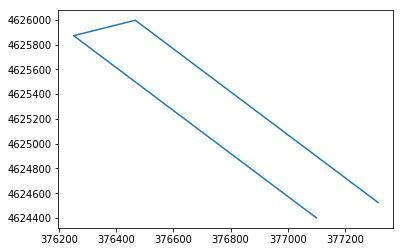

In [43]:
plt.plot(xub, yub,'-')

In [ ]:
from scipy import interpolate
print( np.shape(np.flipud(da['y'].values)), np.shape(da['x'].values), np.shape( np.flipud(da.values)) )
x = da['x'].values
y = np.flipud(da['y'].values)
# Not sure how da.values got a singleton dimension, but squeeze gets rid of it.
# However, make sure to squeeze before flipping
z = np.flipud(np.squeeze(da.values))
print(np.shape(x),np.shape(y),np.shape(z))
f = interpolate.RegularGridInterpolator( (y, x), z, method='linear')

In [ ]:
z[z<=-100.]=np.NaN
plt.pcolormesh(x,y,z)
plt.plot(xub,yub,'-r')
plt.colorbar()
np.shape(xu)

%%time
zi = f((yu,xu))
zi[zi<=-100.]=np.NaN

In [ ]:
%%time
# Array for interpolated elevations
zi=np.NaN*np.ones((ny,nx))

# this is a slow iteration through all of the points, but allows us to skip ones that are outside
for i in np.ndindex(zi.shape):
    try:
        zi[i]=f((yu[i],xu[i]))
    except:
        zi[i]=np.NaN
     

In [ ]:
plt.plot(figsize=(2,8))
plt.pcolormesh(yrot,xrot,zi,cmap=plt.cm.terrain,vmin=-2,vmax=8)
#plt.gca().invert_yaxis()
#plt.axis('equal')
plt.ylim(0,250)
plt.colorbar()

In [ ]:
print(np.shape(zi))
plt.plot(zi[0,:])
plt.ylim(-2,8)

In [ ]:
plt.plot(xu,yu,'.')

In [ ]:
plt.plot(figsize=(2,8))

plt.imshow(np.flipud(zi))